# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [44]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 1

## Torus model

In [46]:
def model(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noisemodel(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = model(z0)  # Using Asimov data

In [47]:
ds = swyft.DataStore().init(zdim = zdim, xdim = x0.shape)
head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


## Inference

In [48]:
td = swyft.TrainData(x0 = x0, zdim = zdim, noisemodel = noisemodel, datastore = ds, nsamples = nsamples, parent = None, threshold = 1e-4)
ds.simulate(model)
re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = [[0], [1], [2]])

Simulate:   8%|▊         | 170/2058 [00:00<00:01, 1693.01it/s]

Constrained posterior area: 1.0
Adding 2058 new samples. Run simulator!


Simulate: 100%|██████████| 2058/2058 [00:01<00:00, 1662.98it/s]


In [49]:
re.train(max_epochs = MAX_EPOCHS, nbatch = 32, lr_schedule = [1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Total epochs: 1
Validation losses: [5.307518690824509]
LR iteration 1
Total epochs: 1
Validation losses: [4.773599490523338]
LR iteration 2
Total epochs: 1
Validation losses: [4.792013645172119]


In [50]:
print("Total number of samples in datastore:", len(ds))

Total number of samples in datastore: 2058


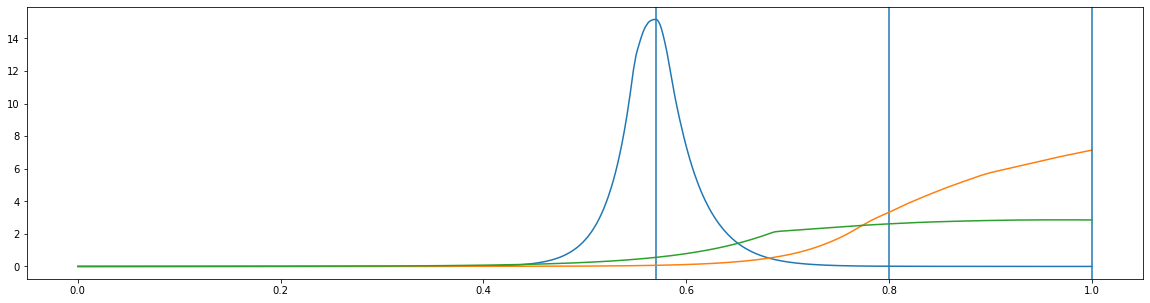

In [63]:
plt.figure(figsize=(20, 5))
for i in range(zdim):
    z, p = re.posterior(x0, i)
    plt.axvline(z0[i])
    plt.plot(z, p)

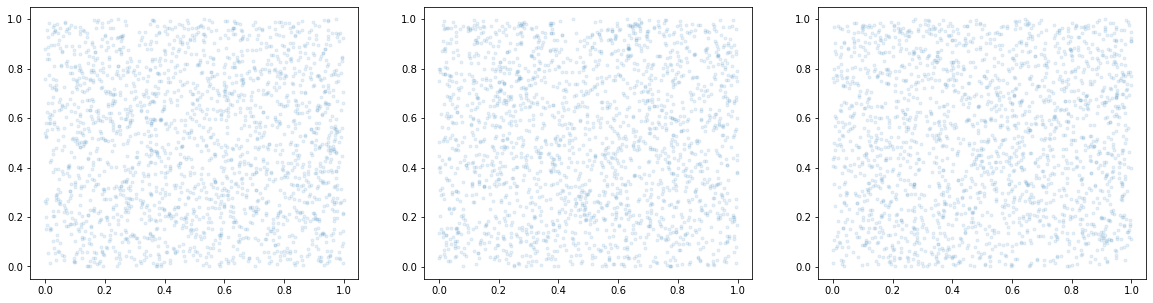

In [52]:
plt.figure(figsize = (20, 5))
plt.subplot(131)
plt.scatter(ds.z[:,0], ds.z[:,1], marker='.', alpha = 0.1)
plt.subplot(132)
plt.scatter(ds.z[:,1], ds.z[:,2], marker='.', alpha = 0.1)
plt.subplot(133)
plt.scatter(ds.z[:,0], ds.z[:,2], marker='.', alpha = 0.1)

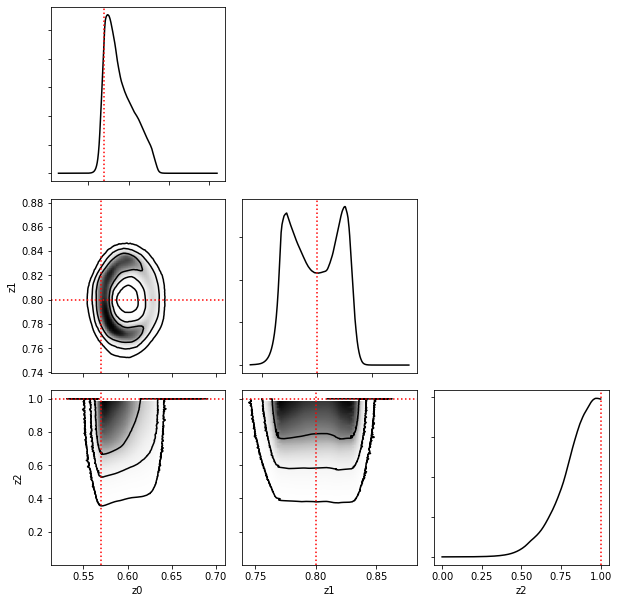

In [41]:
swyft.corner(sw_list[-1], z0 = z0, tag = 'default', cmap = 'Greys', params = [0, 1, 2], dim = 10)
#plt.savefig("corner.pdf")